In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Setting up the Dataset & Workflow

In [2]:
DATASET_PATH = "./data/BTC-USD.csv"
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


# Preprocessing 

In [3]:
df = pd.read_csv(DATASET_PATH, index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)

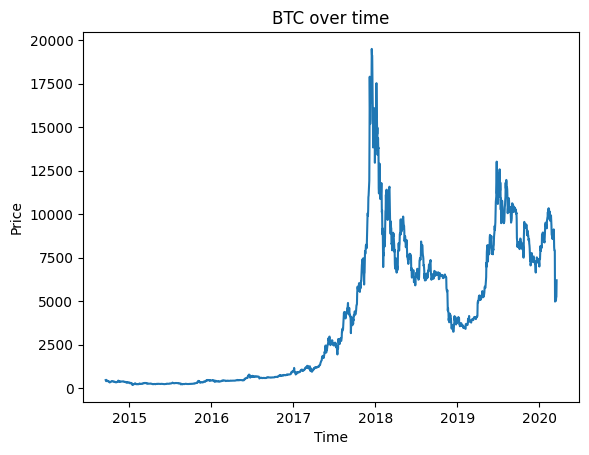

In [4]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("BTC over time")
plt.show()

# Splitting (featues/labels)

In [5]:
features, labels = df.drop(columns=['Close']), df.Close.values
features.shape, labels.shape

((2011, 4), (2011,))

# Normalization

In [6]:
mm = MinMaxScaler()
ss = StandardScaler()

features_transform = ss.fit_transform(features)
labels_transform = mm.fit_transform(labels.reshape(-1, 1)) 

# Splitting (train/test)

In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(features_transform, labels_transform, test_size=0.05, random_state=42)

In [8]:
features_train_tensors = Variable(torch.Tensor(features_train)) 
features_test_tensors = Variable(torch.Tensor(features_test)) 
labels_train_tensors = Variable(torch.Tensor(labels_train)) 
labels_test_tensors = Variable(torch.Tensor(labels_test)) 

# Note
## For LSTM
The size of the input is then  (N,L,Hin) , where  N  is the batch size,  L  is the sequence length, and  Hin  is the input size (i.e. the number of features). In other words, we want the dimensions to be the rows of the dataframe in the first dimension, followed by the length of the dataframe in the next dimension (representing the length of the input sequence), and finally the features (of which we have four) in the final dimension.

In [9]:
features_train_tensors.shape[1]

4

In [10]:
# reshaping to rows, timestamps, features
features_train_tensors_final = torch.reshape(features_train_tensors,   
                                      (features_train_tensors.shape[0], 1, 
                                       features_train_tensors.shape[1]))
features_test_tensors_final = torch.reshape(features_test_tensors,  
                                     (features_test_tensors.shape[0], 1, 
                                      features_test_tensors.shape[1])) 

# Making our model

In [11]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out) 
        out = self.fc2(out)
        return out     

In [12]:
def training_loop(n_epochs, lstm, optimizer, loss_fn, features_train, labels_train, 
                  features_test, labels_test):
    for epoch in tqdm(range(n_epochs)):
        lstm.train()
        outputs = lstm.forward(features_train) # forward pass
        optimizer.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, labels_train)
        loss.backward() # calculates the loss of the loss function
        optimizer.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(features_test)
        test_loss = loss_fn(test_preds, labels_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [13]:
n_epochs = 1177
input_size = 4
hidden_size = 2
num_layers = 1
num_classes = 50

model = LSTM(num_classes, input_size, hidden_size, num_layers)

G:\ml\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [14]:
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
training_loop(n_epochs=n_epochs, lstm=model, optimizer=optimizer, loss_fn=loss_fn,
              features_train=features_train_tensors_final, labels_train=labels_train_tensors,
              features_test=features_test_tensors_final, labels_test=labels_test_tensors)

  0%|          | 0/1177 [00:00<?, ?it/s]

G:\ml\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1910, 1])) that is different to the input size (torch.Size([1910, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
G:\ml\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([101, 1])) that is different to the input size (torch.Size([101, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, train loss: 0.11965, test loss: 0.11809
Epoch: 100, train loss: 0.00966, test loss: 0.01205
Epoch: 200, train loss: 0.00536, test loss: 0.00779
Epoch: 300, train loss: 0.00101, test loss: 0.00197
Epoch: 400, train loss: 0.00047, test loss: 0.00077
Epoch: 500, train loss: 0.00028, test loss: 0.00035
Epoch: 600, train loss: 0.00020, test loss: 0.00021
Epoch: 700, train loss: 0.00016, test loss: 0.00015
Epoch: 800, train loss: 0.00013, test loss: 0.00011
Epoch: 900, train loss: 0.00010, test loss: 0.00010
Epoch: 1000, train loss: 0.00009, test loss: 0.00009
Epoch: 1100, train loss: 0.00008, test loss: 0.00008


In [20]:
model_name=type(model).__name__
torch.save(model.state_dict(), model_name+'_model.pth')

In [16]:
test_pred = model(features_test_tensors_final[-1].unsqueeze(0))
test_pred = test_pred.detach().numpy()
test_pred = mm.inverse_transform(test_pred)
test_pred = test_pred[0].tolist()

test_target = labels_test_tensors[-1].detach().numpy()
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()
test_pred

[7242.1748046875,
 7209.25634765625,
 7200.07861328125,
 7209.53076171875,
 7224.94873046875,
 7197.564453125,
 7176.46142578125,
 7234.810546875,
 7200.919921875,
 7185.95556640625,
 7215.0205078125,
 7227.84375,
 7235.0458984375,
 7204.80908203125,
 7245.51513671875,
 7225.72216796875,
 7187.3134765625,
 7224.63330078125,
 7221.078125,
 7266.29736328125,
 7226.994140625,
 7214.314453125,
 7220.5283203125,
 7171.92578125,
 7239.64794921875,
 7181.96337890625,
 7245.07177734375,
 7205.54296875,
 7230.0927734375,
 7189.611328125,
 7179.74853515625,
 7187.640625,
 7207.16357421875,
 7236.82958984375,
 7221.62548828125,
 7197.99560546875,
 7219.6259765625,
 7212.36328125,
 7235.2216796875,
 7204.05908203125,
 7200.44775390625,
 7213.98388671875,
 7220.9375,
 7235.0234375,
 7181.73974609375,
 7168.7060546875,
 7209.783203125,
 7168.39013671875,
 7222.7841796875,
 7204.68603515625]

Now we will use a split sequence function (credits to charlieoneil11)

In [22]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [24]:
X_ss, y_mm = split_sequences(features_transform, labels_transform, 100, 50)
print(X_ss.shape, y_mm.shape)

(1863, 100, 4) (1863, 50)


In [26]:
total_samples = len(features)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

In [27]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [28]:
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2]))

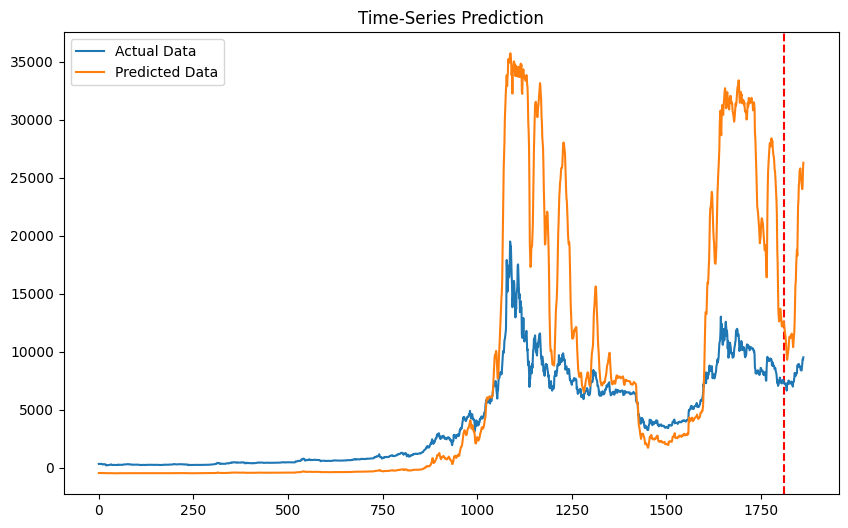

In [35]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = model(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 